In [37]:
# Setup

import pandas as pd
import numpy as np
import requests
import os
import json
import matplotlib.pyplot as plt 
%matplotlib inline
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

#Make the plots pretty
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='k'#'#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='k'#'#333F4B'
plt.rcParams['ytick.color']='k'#'#333F4B'
plt.rcParams.update({'font.size': plt_txt})
blue = '#0091ea'
green = '#00c853'
orange = '#ffab00'

#These are the lat/lon of the boundaries of the map image we're using
IMAGE_TOP = 51.33
IMAGE_BOT = 23.53
IMAGE_LEFT = -127.45
IMAGE_RIGHT = -65.15
bbox = (IMAGE_LEFT, IMAGE_RIGHT, IMAGE_BOT, IMAGE_TOP)

GET_URL = "https://api.is-conic.com/api/v0p1/debug/get_data"

# First, we'll load in data from our server and convert it into a pandas dataframe.

In [25]:
header = {"Content-Type": "application/json"}
response = requests.request("GET", GET_URL, headers=header, verify=False)
if response.status_code != 200:
    raise Exception(response.status_code, response.text)
json_data = response.json()
df = pd.DataFrame.from_dict(json_data)

#look at data after March 9, 2021, Midnight PST (the number is that time in Unix time)
df = df[df['timestamp'] >= 1615276860]

/Users/ArjunTambe/opt/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.is-conic.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


# Next, we'll create a map image to show where all of our sensors are. 
# For now, there's only one. 

(23.53, 51.33)

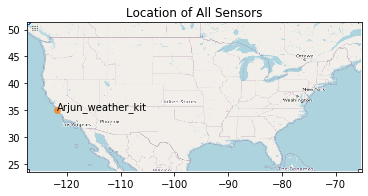

In [15]:
map_df = df.drop_duplicates(subset=['lat', 'lon'])

fig, ax = plt.subplots()

#plot the points and annotate the station id
ax.scatter('lon', 'lat', zorder=1, alpha= 0.7, c='C1', data=map_df)
for i in range(len(map_df)):
    ax.annotate(map_df.iloc[i]['key'], (map_df.iloc[i]['lon'], map_df.iloc[i]['lat']))

#load in the map image in the background
background_map = plt.imread(os.getcwd() + "/usa_map.png")
ax.imshow(background_map, zorder=0, extent = bbox, aspect= 'equal')

#labels and bounds
ax.set_title('Location of All Sensors')
ax.set_xlim(IMAGE_LEFT, IMAGE_RIGHT)
ax.set_ylim(IMAGE_BOT, IMAGE_TOP)

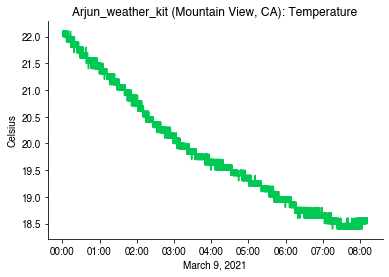

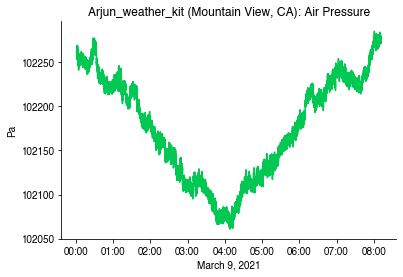

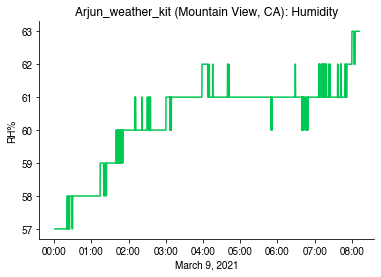

In [39]:
plot_df = df[~df['timestamp'].isna()].sort_values('timestamp', axis=0)
#convert to datetime. subtract 8 hours to get to PST
plot_df['timestamp'] = plot_df['timestamp'].apply(lambda x: \
    datetime.utcfromtimestamp(x-28800))
grouped = plot_df.groupby(['key', 'unit'], as_index=False)
date_form = DateFormatter("%H:%M")

unit_to_mode = {"Celsius":"Temperature", "Pa":"Air Pressure", "RH%":"Humidity"}

for name, grp in grouped:
    fig, ax = plt.subplots()  
    ax.plot('timestamp', 'value', color=green, data=grp)
    ax.set_title("{} (Mountain View, CA): {}".format(name[0], unit_to_mode[name[1]]))
    ax.set_ylabel(name[1])
    ax.set_xlabel("March 9, 2021")
    ax.xaxis.set_major_formatter(date_form)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    plt.show()